In [24]:
import os
import numpy as np
import pandas as pd
import re
from collections import Counter
from nltk.corpus import stopwords
import nltk

In [14]:
# Paths
data_dir = '../data/'
pos_train_path = os.path.join(data_dir, "train_pos_full.txt")
neg_train_path = os.path.join(data_dir, "train_neg_full.txt")
test_path = os.path.join(data_dir, "test_data.txt")

In [15]:
# Load the data
with open(pos_train_path, 'r', encoding='utf-8') as f:
    pos_tweets = f.read().splitlines()

with open(neg_train_path, 'r', encoding='utf-8') as f:
    neg_tweets = f.read().splitlines()

with open(test_path, 'r', encoding='utf-8') as f:
    test_tweets = f.read().splitlines()

# Convert to DataFrames
pos_df = pd.DataFrame({'tweet': pos_tweets, 'label': 1})
neg_df = pd.DataFrame({'tweet': neg_tweets, 'label': 0})
test_df = pd.DataFrame({'tweet': test_tweets})

# Combine datasets
train_df = pd.concat([pos_df, neg_df], ignore_index=True)

### 1. Check for Missing values in our data

In [16]:
print("Missing values in train_df:")
print(train_df.isnull().sum())


Missing values in train_df:
tweet    0
label    0
dtype: int64


### 2. Check our label distribution, to see if we have imbalanced class

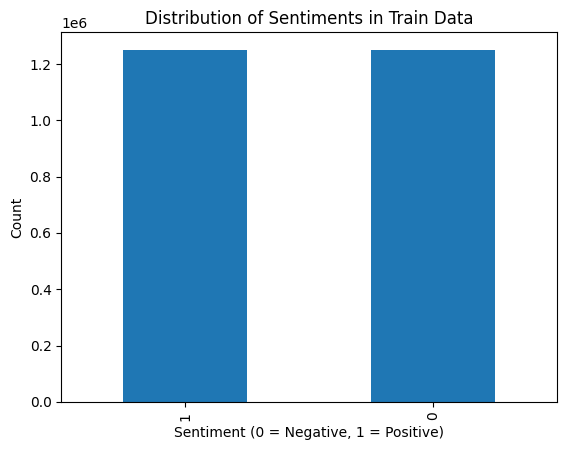

In [17]:
import matplotlib.pyplot as plt

# Distribution of labels in train data
train_df['label'].value_counts().plot(kind='bar')
plt.title("Distribution of Sentiments in Train Data")
plt.xlabel("Sentiment (0 = Negative, 1 = Positive)")
plt.ylabel("Count")
plt.show()


### 3. Text length Analysis

In [18]:
# Add length column
train_df['tweet_length'] = train_df['tweet'].apply(len)
test_df['tweet_length'] = test_df['tweet'].apply(len)

# Summary statistics
print("Tweet Length Summary (Train):")
print(train_df['tweet_length'].describe())

print("\nTweet Length Summary (Test):")
print(test_df['tweet_length'].describe())


Tweet Length Summary (Train):
count    2.500000e+06
mean     7.596408e+01
std      3.542579e+01
min      3.000000e+00
25%      4.600000e+01
50%      7.100000e+01
75%      1.110000e+02
max      4.010000e+02
Name: tweet_length, dtype: float64

Tweet Length Summary (Test):
count    10000.000000
mean        80.729700
std         34.931852
min         15.000000
25%         51.000000
50%         75.000000
75%        115.000000
max        176.000000
Name: tweet_length, dtype: float64


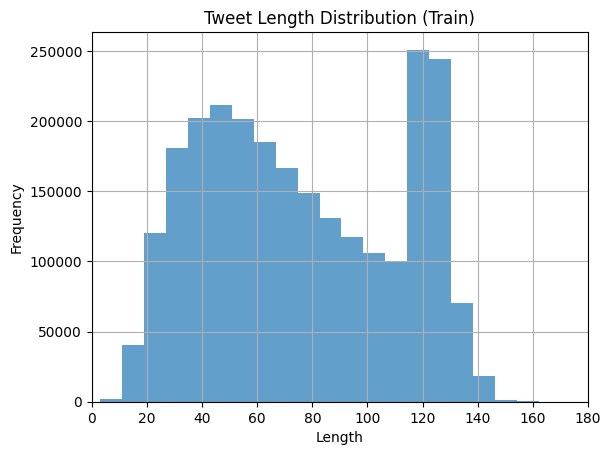

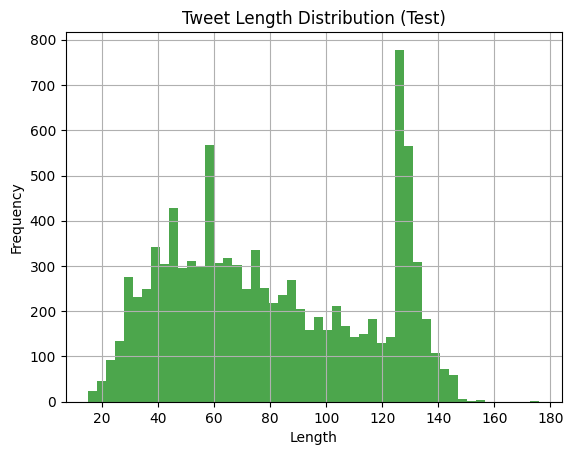

In [19]:
# Train Data
train_df['tweet_length'].hist(bins=50, alpha=0.7)
plt.title("Tweet Length Distribution (Train)")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.xlim(0,180)
plt.show()

# Test Data
test_df['tweet_length'].hist(bins=50, alpha=0.7, color='green')
plt.title("Tweet Length Distribution (Test)")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()


### 4. Common word Analysis

In [25]:
# Download stopwords from NLTK
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Tokenization and cleaning function
def clean_tokenize(tweet):
    tweet = re.sub(r'http\S+|www\S+', '', tweet)  # Remove URLs
    tweet = re.sub(r'@\w+', '', tweet)           # Remove mentions
    tweet = re.sub(r'#', '', tweet)              # Remove hashtags symbol
    tweet = re.sub(r'[^A-Za-z\s]', '', tweet)    # Remove special characters
    tweet = re.sub(r'\buser\b|\b<user>\b', '', tweet, flags=re.IGNORECASE)  # Remove 'user' or '<user>'
    tweet = re.sub(r'\burl\b', '', tweet, flags=re.IGNORECASE)  # Remove the word 'url'
    tokens = tweet.lower().split()              # Convert to lowercase and split into tokens
    tokens = [word for word in tokens if word not in stop_words]  # Remove stop words
    return tokens

# Tokenize tweets
train_df['tokens'] = train_df['tweet'].apply(clean_tokenize)
test_df['tokens'] = test_df['tweet'].apply(clean_tokenize)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adamouazzani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
# Combine all tokens
all_tokens = [word for tokens in train_df['tokens'] for word in tokens]
word_freq = Counter(all_tokens)

# Display most common words
print("Most Common Words in Train Data:")
print(word_freq.most_common(20))


Most Common Words in Train Data:
[('im', 229656), ('rt', 143659), ('love', 124674), ('like', 120373), ('dont', 110465), ('get', 108058), ('frame', 102408), ('x', 101673), ('u', 98964), ('lol', 97001), ('good', 96390), ('know', 96046), ('one', 94793), ('follow', 92921), ('go', 88095), ('please', 82064), ('day', 80927), ('cant', 75532), ('see', 73251), ('want', 72450)]


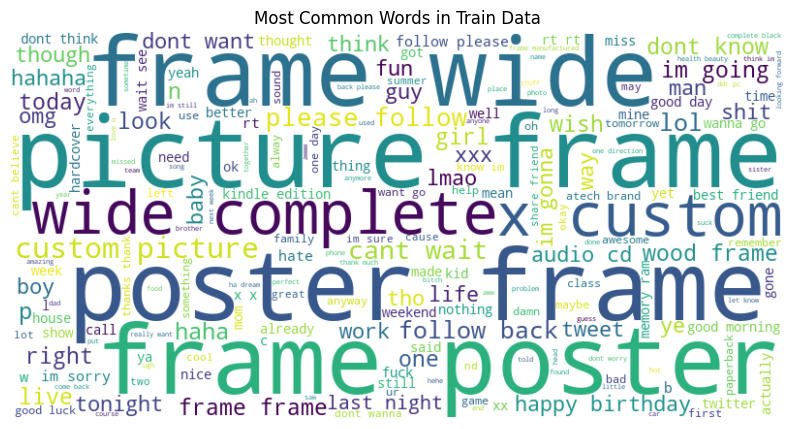

In [27]:
from wordcloud import WordCloud

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_tokens))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Train Data")
plt.show()


### 5. Hashtag analysis

In [28]:
# Extract hashtags
train_df['hashtags'] = train_df['tweet'].apply(lambda x: re.findall(r'#\w+', x))
test_df['hashtags'] = test_df['tweet'].apply(lambda x: re.findall(r'#\w+', x))

# Analyze hashtags
all_hashtags = [hashtag for hashtags in train_df['hashtags'] for hashtag in hashtags]
hashtag_freq = Counter(all_hashtags)
print("Most Common Hashtags:")
print(hashtag_freq.most_common(10))


Most Common Hashtags:
[('#oomf', 4693), ('#ff', 4449), ('#yougetmajorpointsif', 3380), ('#teamfollowback', 2208), ('#thoughtsduringschool', 1811), ('#sadtweet', 1790), ('#smartnokialumia', 1651), ('#waystomakemehappy', 1513), ('#jobs', 1237), ('#np', 1204)]


### 6. Sentimental Analysis

In [29]:
# Separate positive and negative tweets
positive_tweets = train_df[train_df['label'] == 1]['tokens']
negative_tweets = train_df[train_df['label'] == 0]['tokens']

# Flatten lists
positive_words = [word for tokens in positive_tweets for word in tokens]
negative_words = [word for tokens in negative_tweets for word in tokens]

# Most common words
positive_freq = Counter(positive_words).most_common(20)
negative_freq = Counter(negative_words).most_common(20)

print("Most Common Positive Words:")
print(positive_freq)

print("\nMost Common Negative Words:")
print(negative_freq)


Most Common Positive Words:
[('im', 117499), ('love', 91405), ('rt', 87297), ('good', 72458), ('follow', 71842), ('lol', 66990), ('like', 65751), ('thanks', 62515), ('u', 59748), ('get', 59384), ('know', 55071), ('day', 51248), ('please', 50710), ('one', 50502), ('dont', 49373), ('haha', 43221), ('see', 41628), ('back', 40791), ('go', 40349), ('x', 37833)]

Most Common Negative Words:
[('im', 112157), ('frame', 102308), ('x', 63840), ('dont', 61092), ('rt', 56362), ('like', 54622), ('get', 48674), ('go', 47746), ('cant', 47198), ('one', 44291), ('paperback', 43646), ('want', 42254), ('miss', 41170), ('know', 40975), ('u', 39216), ('really', 36460), ('love', 33269), ('black', 32355), ('pack', 31997), ('see', 31623)]


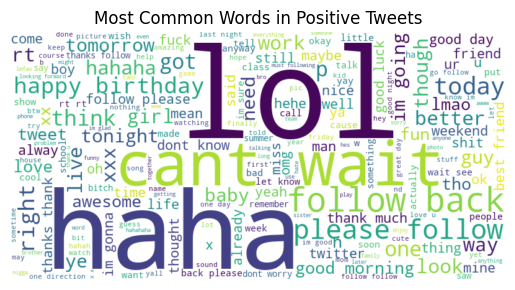

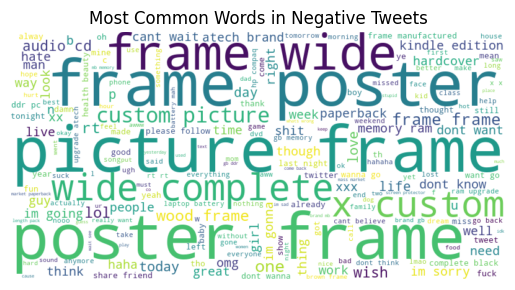

In [30]:
# Positive Word Cloud
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_words))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Positive Tweets")
plt.show()

# Negative Word Cloud
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(negative_words))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Negative Tweets")
plt.show()


### 7. N-gram Analysis

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

# Separate positive and negative tweets
positive_tweets = train_df[train_df['label'] == 1]['tweet']
negative_tweets = train_df[train_df['label'] == 0]['tweet']

# Bi-gram analysis for positive tweets
vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=20)
X_bigrams_pos = vectorizer.fit_transform(positive_tweets)
bigram_freq_pos = dict(zip(vectorizer.get_feature_names_out(), X_bigrams_pos.toarray().sum(axis=0)))
print("Most Common Bi-Grams in Positive Tweets:")
print(sorted(bigram_freq_pos.items(), key=lambda x: x[1], reverse=True))

# Bi-gram analysis for negative tweets
X_bigrams_neg = vectorizer.fit_transform(negative_tweets)
bigram_freq_neg = dict(zip(vectorizer.get_feature_names_out(), X_bigrams_neg.toarray().sum(axis=0)))
print("Most Common Bi-Grams in Negative Tweets:")
print(sorted(bigram_freq_neg.items(), key=lambda x: x[1], reverse=True))

# Tri-gram analysis for positive tweets
vectorizer = CountVectorizer(ngram_range=(3, 3), max_features=20)
X_trigrams_pos = vectorizer.fit_transform(positive_tweets)
trigram_freq_pos = dict(zip(vectorizer.get_feature_names_out(), X_trigrams_pos.toarray().sum(axis=0)))
print("Most Common Tri-Grams in Positive Tweets:")
print(sorted(trigram_freq_pos.items(), key=lambda x: x[1], reverse=True))

# Tri-gram analysis for negative tweets
X_trigrams_neg = vectorizer.fit_transform(negative_tweets)
trigram_freq_neg = dict(zip(vectorizer.get_feature_names_out(), X_trigrams_neg.toarray().sum(axis=0)))
print("Most Common Tri-Grams in Negative Tweets:")
print(sorted(trigram_freq_neg.items(), key=lambda x: x[1], reverse=True))


Most Common Bi-Grams in Positive Tweets:
[('user user', 144576), ('rt user', 61006), ('thank you', 29557), ('if you', 28106), ('in the', 26894), ('user thanks', 25877), ('you re', 25371), ('for the', 25274), ('user you', 24578), ('follow me', 21544), ('love you', 21010), ('to be', 20738), ('going to', 18912), ('on the', 16951), ('the best', 16657), ('user haha', 16602), ('user lol', 16075), ('to the', 15737), ('to see', 15273), ('thanks for', 14943)]
Most Common Bi-Grams in Negative Tweets:
[('user user', 64995), ('rt user', 49554), ('in the', 34249), ('of the', 33112), ('picture frame', 25647), ('poster frame', 25408), ('frame poster', 25407), ('wide complete', 25035), ('this frame', 24685), ('custom picture', 24002), ('frame is', 23727), ('pack of', 22536), ('want to', 20796), ('to be', 19863), ('to go', 17942), ('going to', 17744), ('to the', 17309), ('have to', 16887), ('on the', 15813), ('for the', 14935)]
Most Common Tri-Grams in Positive Tweets:
[('user user user', 50145), ('rt 